In [3]:
import sys
import random
from mysvm import SVM
import numpy as np
from sklearn.linear_model import SGDClassifier as SGD
from pyspark import SparkContext,SparkConf
from sklearn.base import copy

# Spark with SGDClassifier

In [ ]:
def fit_in(x,svm):
    for it in x:
        X=it[:-1].reshape(1,it.shape[0]-1)
        y=np.array([it[-1]])
        svm.partial_fit(X,y,classes=[-1,1])
    yield svm
def update_in(m1,m2):
    new_mod=copy.deepcopy(m1)
    new_mod.coef_+=m2.coef_
    new_mod.intercept_+=m2.intercept_
    return new_mod

def avg_coefs_in(svm,numpart):
    svm.coef_/=numpart
    svm.intercept_/=numpart
    return svm

In [4]:
conf=SparkConf().setAppName("SVM-SGD").setMaster('local[4]')

In [5]:
sc=SparkContext(conf=conf)

In [6]:
X1=5*np.random.random((400,2))-3
y1=-1*np.ones(X1.shape[0])
X2=6*(np.random.random((400,2)))+7
y2=np.ones(X2.shape[0])
y=np.hstack((y1,y2))
X=np.vstack((X1,X2))
y=y.reshape(y.shape[0],1)
X=np.hstack((X,y))

In [16]:
svm=SGD(alpha=1,learning_rate='constant',eta0=0.1)
prev_coef=np.zeros(X.shape[1]-1)
prev_intercept=0
tol=0.001
max_iter=300

In [ ]:
for i in range(max_iter):
    dat=sc.parallelize(X)
    svm=dat.mapPartitions(lambda x:fit_in(x,svm)).reduce(lambda m1,m2:update_in(m1,m2))
    svm=avg_coefs_in(svm,dat.getNumPartitions())
    diff_coef=svm.coef_[0]-prev_coef
    diff_intercept=svm.intercept_[0]-prev_intercept
    gradient_sum=np.sqrt(np.dot(diff_coef,diff_coef)+diff_intercept**2)
    if gradient_sum<tol:
        break
    prev_coef=svm.coef_[0]
    prev_intercept=svm.intercept_[0]
    np.random.shuffle(X)
print(svm.coef_)
print(svm.intercept_)

In [10]:
import seaborn as sns

In [ ]:
def hyperplane(X,svm):
    y=-(svm.intercept_+np.dot(X[:,:-1],svm.coef_[0][:-1]))/svm.coef_[0][-1]
    return y
def support_vec(X,svm,off):
    y=(off-svm.intercept_-np.dot(X[:,:-1],svm.coef_[0][:-1]))/svm.coef_[0][-1]
    return y


In [ ]:
y=hyperplane(X[:,:-1],svm)
s1=support_vec(X[:,:-1],svm,1)
s2=support_vec(X[:,:-1],svm,-1)
sns.scatterplot(X[:,0],X[:,1],hue=X[:,-1])
sns.lineplot(X[:,0],s1)
sns.lineplot(X[:,0],s2)
sns.lineplot(X[:,0],y)

## Spark with my implementation of SVM using SGD

In [1]:
def fit(x,svm):
    for it in x:
        X=it[:-1].reshape(1,it.shape[0]-1)
        y=np.array([it[-1]])
        svm.partial_fit(X,y)
    yield svm
def update(m1,m2):
    new_mod=copy.deepcopy(m1)
    new_mod.weights+=m2.weights
    new_mod.intercept+=m2.intercept
    return new_mod

def avg_coefs(svm,numpart):
    svm.weights/=numpart
    svm.intercept/=numpart
    return svm

In [15]:
max_iter=20
l=1
alpha=0.01
sv=SVM(alpha,max_iter,l)
prev_coef=np.zeros(X.shape[1]-1)
prev_intercept=0
tol=0.001

In [13]:
for i in range(max_iter):
    dat=sc.parallelize(X)
    sv=dat.mapPartitions(lambda x:fit(x,sv)).reduce(lambda m1,m2:update(m1,m2))
    sv=avg_coefs(sv,dat.getNumPartitions())
    diff_coef=sv.weights-prev_coef
    diff_intercept=sv.intercept-prev_intercept
    gradient_sum=np.sqrt(np.dot(diff_coef,diff_coef)+diff_intercept**2)
    if gradient_sum<tol:
        break
    prev_coef=sv.weights
    prev_intercept=sv.intercept
    np.random.shuffle(X)
print(sv.weights)
print(sv.intercept)

[0.1729322  0.18826772]
-1.4000000000000012


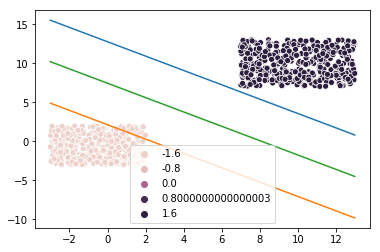

In [14]:
y=sv.hyperplane_coord(X[:,:-1])
s1=sv.support_vec(X[:,:-1],1)
s2=sv.support_vec(X[:,:-1],-1)
sns.scatterplot(X[:,0],X[:,1],hue=X[:,-1])
sns.lineplot(X[:,0],s1)
sns.lineplot(X[:,0],s2)
sns.lineplot(X[:,0],y)

In [ ]:
X=np.array([1,2,3,4,5,6,7,8])

In [ ]:
prev_coef